In [1]:
# import relevant packages
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from acquire import get_crime_data
from datetime import datetime
import prepare
import seaborn as sns
from wrangle import *
from explore import *

In [2]:
# plotting defaults
plt.rc('figure', figsize=(23, 10))
plt.style.use('seaborn-dark-palette')
plt.rc('font', size=16)

In [3]:
df = get_crime_data(use_cache = False)

Acquiring data from api


In [4]:
df = wrangle_crime_data()

Using cached csv


In [5]:
df.crime_type.count()

349581

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 349581 entries, 34573 to 436549
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   crime_type        349581 non-null  object        
 1   family_violence   349581 non-null  object        
 2   occurrence_time   349581 non-null  datetime64[ns]
 3   occurrence_date   349581 non-null  datetime64[ns]
 4   report_time       349581 non-null  datetime64[ns]
 5   report_date       349581 non-null  datetime64[ns]
 6   location_type     349581 non-null  object        
 7   address           349581 non-null  object        
 8   zip_code          349581 non-null  float64       
 9   council_district  349581 non-null  float64       
 10  sector            349581 non-null  object        
 11  district          349581 non-null  object        
 12  latitude          349581 non-null  float64       
 13  longitude         349581 non-null  float64       
 14  

In [7]:
#Assign my .shp file to a variable named “asutin_map”
#austin_map = gpd.read_file('Boundaries_zipcode/geo_export_9b5aa23d-57b1-41f4-b4f9-0a9d97fac540.shp')

In [8]:
#austin_map = austin_map.drop(columns =['affgeoid10','geoid10','aland10','awater10'])

In [9]:
#austin_map = austin_map.rename(columns ={'zcta5ce10': 'zip_code'})

In [10]:
#austin_map = austin_map.astype({"zip_code": float}, errors='raise') 

In [11]:
#create a new dataframe with both our geographical and statistical data in it by merging our two tables together.
#new_df = austin_map.merge(df, on ='zip_code')

In [12]:
#new_df.to_csv('Geo_Crime_Reports.csv')

In [13]:
#new_df.info()

In [15]:
#new_df.head()

In [16]:
#Crime_type by zip_code
#fig, ax = plt.subplots(1, figsize=(8, 8))
#plt.xticks(rotation=90)
#new_df.plot(column="crime_type", cmap="Reds", linewidth=0.4, ax=ax, edgecolor=".4")
#bar_info = plt.cm.ScalarMappable(cmap="Reds", norm=plt.Normalize(vmin=0, vmax=120))
#bar_info._A = []
#cbar = fig.colorbar(bar_info)

# We predict that there is a relationship between higher seasonal levels of crime and clearance status.

In [17]:
train, validate, test = prepare.split_data(df)

In [18]:
train.shape

(195764, 17)

In [40]:
train2 = train.copy()

In [41]:
#df['occurrence_date']= pd.to_datetime(df['occurrence_date'])
train2 = train2.set_index('occurrence_time').sort_index()

In [42]:
#Split by month first
train2['month'] = train2.index.month_name()
train2['weekdays'] = train2.index.day_name()
train2['year'] = train2.index.year

In [43]:
#train2.groupby(train2.occurrence_date.dt.month).crime_type.count().idxmax()

In [44]:
y = train2.groupby(['weekdays','year'])['crime_type'].count()

In [45]:
y

weekdays   year
Friday     2018    7601
           2019    8069
           2020    7505
           2021    6667
Monday     2018    7226
           2019    7540
           2020    7099
           2021    6410
Saturday   2018    7441
           2019    7641
           2020    6955
           2021    6114
Sunday     2018    7074
           2019    7419
           2020    6817
           2021    6078
Thursday   2018    7116
           2019    7081
           2020    7144
           2021    6071
Tuesday    2018    6970
           2019    7295
           2020    7037
           2021    5901
Wednesday  2018    7039
           2019    7082
           2020    7336
           2021    6036
Name: crime_type, dtype: int64

In [46]:
y_max = train2.groupby(['weekdays','year'])['crime_type'].count().max()

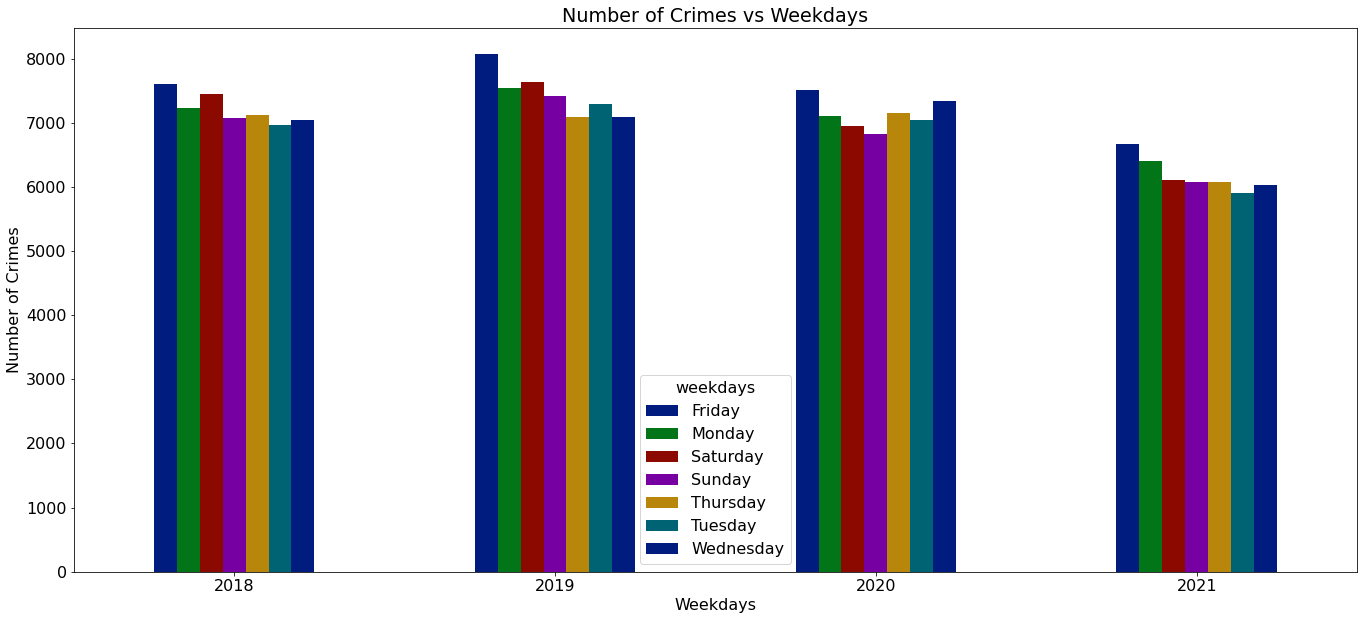

In [47]:
#Take a look at all the crime types
train2['weekdays'] = pd.Categorical(train2['weekdays'], categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
#overall_mean = df.groupby('month').crime_type.value_counts()
#Assuming 0 = Sunday, 1 = Monday, 2 = Tuesday, 3 = Wednesday, 4 = Thursday, 5 = Friday, 6 =Saturday
y.unstack(0).plot.bar()
#sns.barplot(x=None, y = y, data = y, ci = None)
plt.title("Number of Crimes vs Weekdays")
plt.xlabel("Weekdays")
plt.ylabel("Number of Crimes")
plt.tick_params('x', rotation=360)
#plt.axhline(overall_mean,color="r")
None

In [48]:
friday_only = ['Friday']

In [49]:
subset_friday = train2.copy()

In [50]:
subset_friday = subset_friday[subset_friday.weekdays.isin(friday_only)]#With just friday only

In [51]:
subset_not_friday = train2.copy()

In [52]:
subset_not_friday = subset_not_friday[~subset_not_friday.weekdays.isin(friday_only)]#Without friday

### Stats Test

We'll be testing the following hypothesis:

$H_0$: There is no difference in crime levels between Fridays and other days of the week.
<br>
$H_a$: There is difference in crime levels between Fridays and other days of the week.

In [53]:
#Do 1 sample t-test compare friday vs the rest
#Need to subset the data just friday only and other exclude the friday and do 1 sample ttest
t_test_ind(subset_not_friday.cleared, subset_friday.cleared)

The t value between the two samples is 0.6367 and the P-Value is 0.5243498607925576.
----------------------------------------------------------------------------
Since the P value is greater than the alpha, we fail to reject the null hypothesis.


In [54]:
train2.head()

,crime_type,family_violence,occurrence_date,report_time,report_date,location_type,address,zip_code,council_district,sector,district,latitude,longitude,clearance_status,clearance_date,cleared,month,weekdays,year
occurrence_time,,,,,,,,,,,,,,,,,,,
2018-01-01,IDENTITY THEFT,N,2018-01-01,2022-03-30 19:47:00,2022-03-30,RESIDENCE / HOME,1115 TOWN CREEK DR,78741.0,3.0,HE,2,30.244328,-97.725245,not cleared,2022-04-19,False,January,Monday,2018
2018-01-01,CRIMINAL MISCHIEF,N,2018-01-01,2018-01-04 16:09:00,2018-01-04,RESIDENCE / HOME,12817 SEXSON RIDGE CV,78617.0,2.0,HE,7,30.174692,-97.618642,not cleared,2018-01-29,False,January,Monday,2018
2018-01-01,IDENTITY THEFT,N,2018-01-01,2019-07-17 10:19:00,2019-07-17,RESIDENCE / HOME,1500 E PARMER LN,78753.0,7.0,ED,6,30.389791,-97.651206,not cleared,2019-07-17,False,January,Monday,2018
2018-01-01,HARASSMENT,N,2018-01-01,2018-06-12 20:33:00,2018-06-12,RESIDENCE / HOME,420 W SLAUGHTER LN,78748.0,2.0,FR,3,30.172125,-97.797176,not cleared,2018-06-13,False,January,Monday,2018
2018-01-01,POSS OF FIREARM BY FELON,Y,2018-01-01,2018-01-31 13:09:00,2018-01-31,RESIDENCE / HOME,11513 FAST HORSE DR,78759.0,6.0,AD,2,30.411489,-97.741554,not cleared,2019-01-22,False,January,Monday,2018


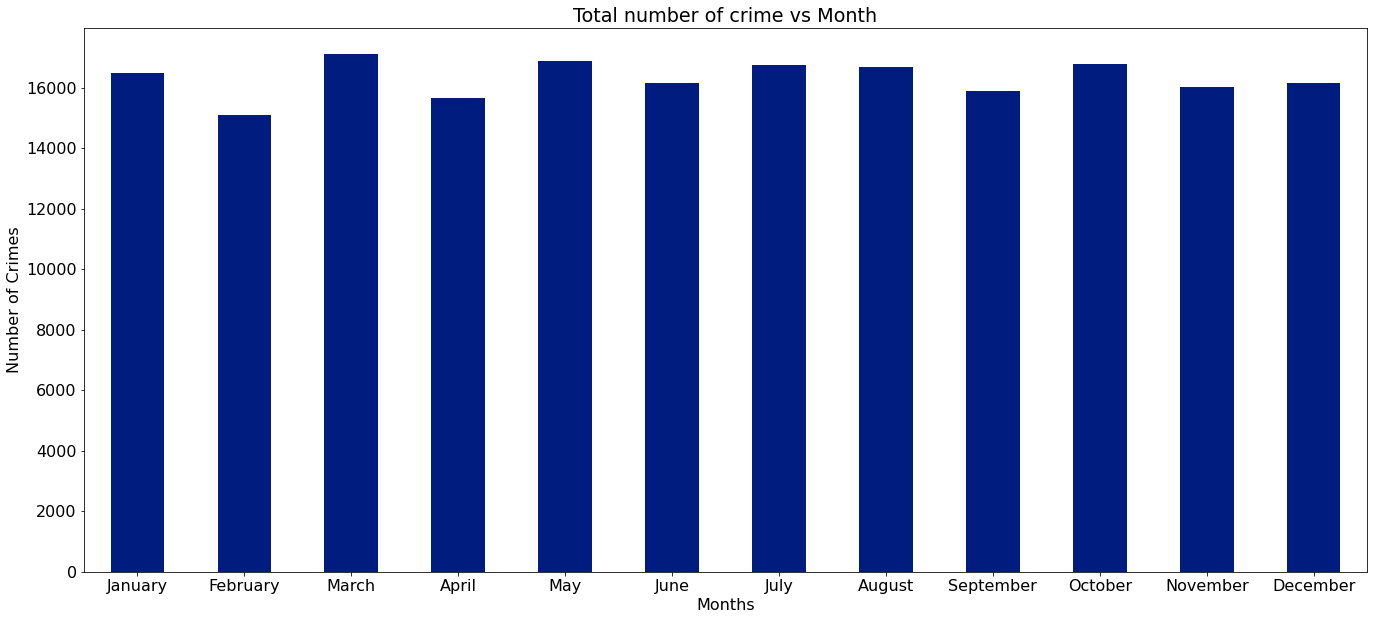

In [55]:
#Take a look at all the crime types
train2['month'] = pd.Categorical(train2['month'], categories=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August',
                                                            'September','October', 'November', 'December'])
#overall_mean = df.groupby('month').crime_type.value_counts()
train2.groupby('month').crime_type.count().plot.bar()
plt.title("Total number of crime vs Month")
plt.xlabel("Months")
plt.ylabel("Number of Crimes")
plt.tick_params('x', rotation=360)
#plt.axhline(overall_mean,color="r")
None

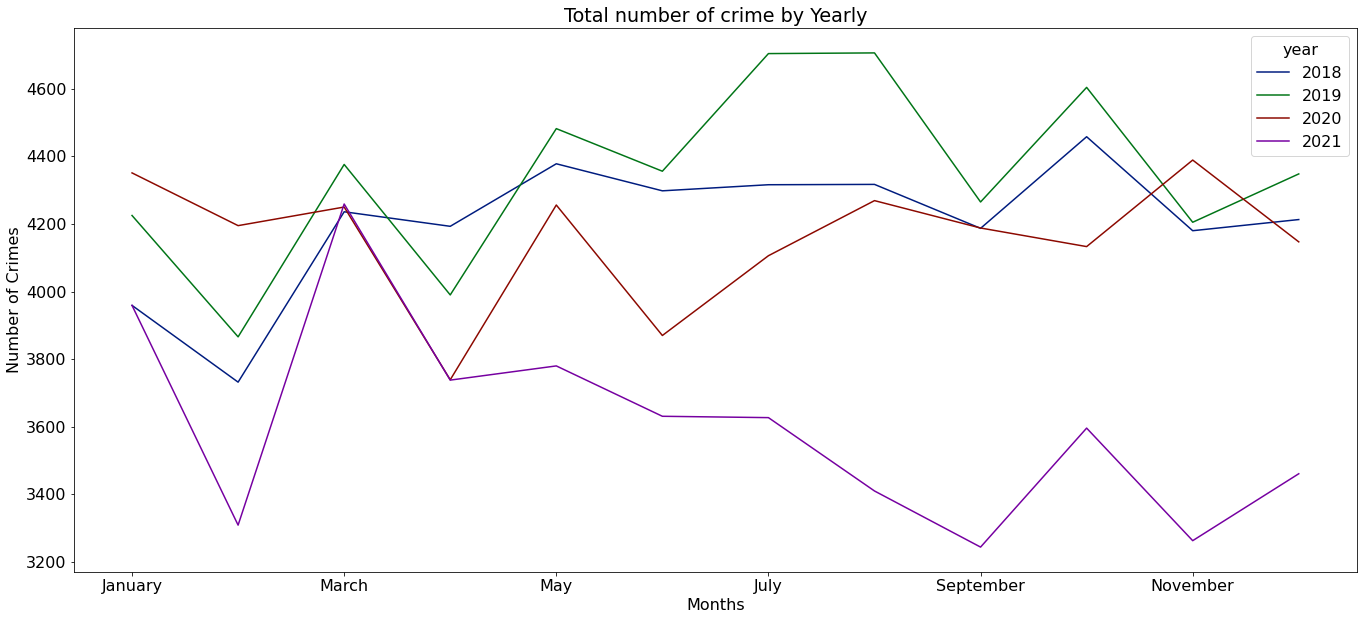

In [56]:
train2.groupby(['year', 'month']).crime_type.count().unstack(0).plot.line()
plt.title("Total number of crime by Yearly")
plt.xlabel("Months")
plt.ylabel("Number of Crimes")
plt.tick_params('x', rotation=360)
#plt.axhline(overall_mean,color="r")
None

#### Take away 
- From the visuals, we can see that Friday (2019) has higest, all the months have almost the same number of crime and year of 2019. But still need to take a look deeper into which weekday of the year has the higest number.

In [60]:
train2 ['report_hour'] = train2.index.hour

In [75]:
train2 = train2.astype({'report_hour':int}, errors='raise')

In [76]:
train2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 195764 entries, 2018-01-01 00:00:00 to 2021-12-31 23:50:00
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   crime_type        195764 non-null  object        
 1   family_violence   195764 non-null  object        
 2   occurrence_date   195764 non-null  datetime64[ns]
 3   report_time       195764 non-null  datetime64[ns]
 4   report_date       195764 non-null  datetime64[ns]
 5   location_type     195764 non-null  object        
 6   address           195764 non-null  object        
 7   zip_code          195764 non-null  float64       
 8   council_district  195764 non-null  float64       
 9   sector            195764 non-null  object        
 10  district          195764 non-null  object        
 11  latitude          195764 non-null  float64       
 12  longitude         195764 non-null  float64       
 13  clearance_status  195764 

In [90]:
train2.report_hour.min

<bound method NDFrame._add_numeric_operations.<locals>.min of occurrence_time
2018-01-01 00:00:00     0
2018-01-01 00:00:00     0
2018-01-01 00:00:00     0
2018-01-01 00:00:00     0
2018-01-01 00:00:00     0
                       ..
2021-12-31 23:00:00    23
2021-12-31 23:00:00    23
2021-12-31 23:20:00    23
2021-12-31 23:47:00    23
2021-12-31 23:50:00    23
Name: report_hour, Length: 195764, dtype: int64>

In [99]:
bins = [0, 4, 12, 17, 24]
labels = [ 'Early Morning', 'Morning', 'Afternoon', 'Evening']

In [100]:
train2 ['report_hour_bins'] = pd.cut(train2['report_hour'], bins = bins, labels = labels, right = False)
                                                    

In [102]:
train2.sample(10)

,crime_type,family_violence,occurrence_date,report_time,report_date,location_type,address,zip_code,council_district,sector,...,latitude,longitude,clearance_status,clearance_date,cleared,month,weekdays,year,report_hour,report_hour_bins
occurrence_time,,,,,,,,,,,,,,,,,,,,,
2020-06-06 23:00:00,THEFT OF BICYCLE,N,2020-06-06,2020-06-08 10:58:00,2020-06-08,RESIDENCE / HOME,4108 CAMACHO ST,78723.0,9.0,BA,...,30.293136,-97.705334,not cleared,2020-06-08,False,June,Saturday,2020,23,Evening
2020-05-27 14:45:00,CRIMINAL MISCHIEF,N,2020-05-27,2020-05-28 08:39:00,2020-05-28,RESIDENCE / HOME,8800 N IH 35 SVRD SB,78753.0,4.0,ED,...,30.352253,-97.692818,not cleared,2020-06-15,False,May,Wednesday,2020,14,Afternoon
2018-02-06 15:26:00,HARASSMENT,N,2018-02-06,2019-02-06 15:26:00,2019-02-06,OTHER / UNKNOWN,813 E 8TH ST,78702.0,1.0,CH,...,30.266889,-97.732962,not cleared,2019-02-26,False,February,Tuesday,2018,15,Afternoon
2018-05-12 18:03:00,THEFT,N,2018-05-12,2018-05-12 18:03:00,2018-05-12,OTHER / UNKNOWN,525 N LAMAR BLVD,78703.0,9.0,GE,...,30.270569,-97.754058,cleared by arrest,2018-05-12,True,May,Saturday,2018,18,Evening
2021-04-19 09:00:00,THEFT CATALYTIC CONVERTER,N,2021-04-19,2021-04-21 16:18:00,2021-04-21,PARKING /DROP LOT/ GARAGE,206 E 9TH ST,78701.0,9.0,GE,...,30.270594,-97.739773,not cleared,2021-04-26,False,April,Monday,2021,9,Morning
2020-04-27 18:13:00,DOC DISCHARGE GUN - PUB ROAD,N,2020-04-27,2020-04-27 18:47:00,2020-04-27,HWY / ROAD / ALLEY/ STREET/ SIDEWALK,6917 VILLITA AVENIDA,78741.0,3.0,HE,...,30.230076,-97.690811,not cleared,2020-04-30,False,April,Monday,2020,18,Evening
2019-05-16 08:00:00,THEFT OF BICYCLE,N,2019-05-16,2019-05-16 13:10:00,2019-05-16,RESIDENCE / HOME,2011 HASKELL ST,78702.0,3.0,CH,...,30.251640,-97.724648,not cleared,2019-05-29,False,May,Thursday,2019,8,Morning
2018-08-30 03:40:00,ASSAULT BY THREAT,N,2018-08-30,2018-08-30 13:45:00,2018-08-30,HWY / ROAD / ALLEY/ STREET/ SIDEWALK,501 W 5TH ST,78701.0,9.0,GE,...,30.268109,-97.748430,not cleared,2018-09-04,False,August,Thursday,2018,3,Early Morning
2021-06-07 12:16:00,ONLINE SOLICITATION OF A MINOR,N,2021-06-07,2021-06-07 12:16:00,2021-06-07,RESIDENCE / HOME,4111 AVENUE C,78751.0,9.0,BA,...,30.305698,-97.732347,not cleared,2021-07-19,False,June,Monday,2021,12,Afternoon


In [135]:
train2.report_hour_bins.value_counts()

Evening          75313
Afternoon        49372
Morning          38886
Early Morning    32193
Name: report_hour_bins, dtype: int64

<AxesSubplot:xlabel='weekdays,clearance_status'>

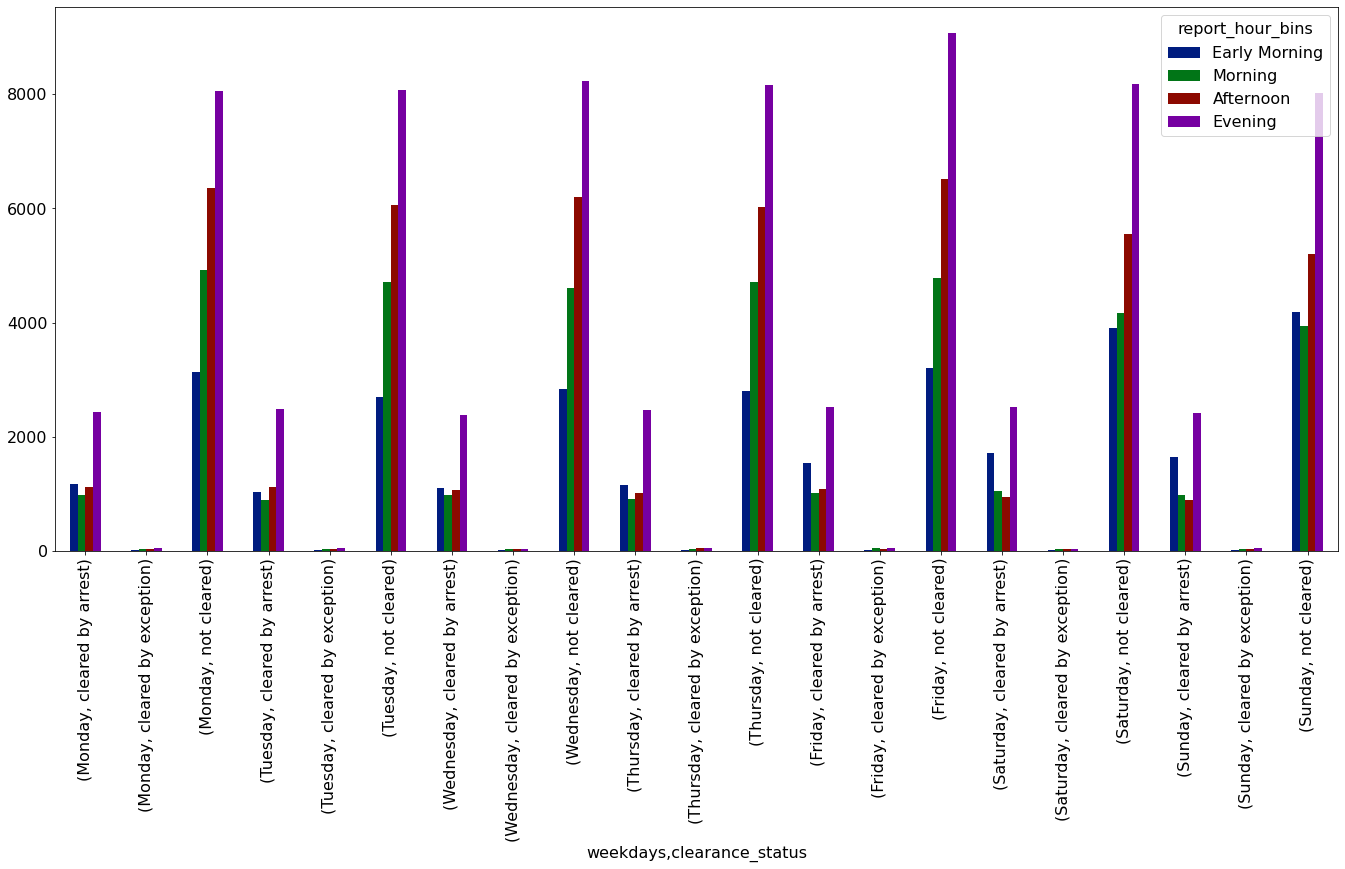

In [162]:
#Quick visual
train2.groupby(['report_hour_bins','weekdays', 'clearance_status']).crime_type.count().unstack(0).plot.bar()

In [116]:
#Note: During the evening time there is more crime compare to early morning. But which crime is more like to happen at that hour?

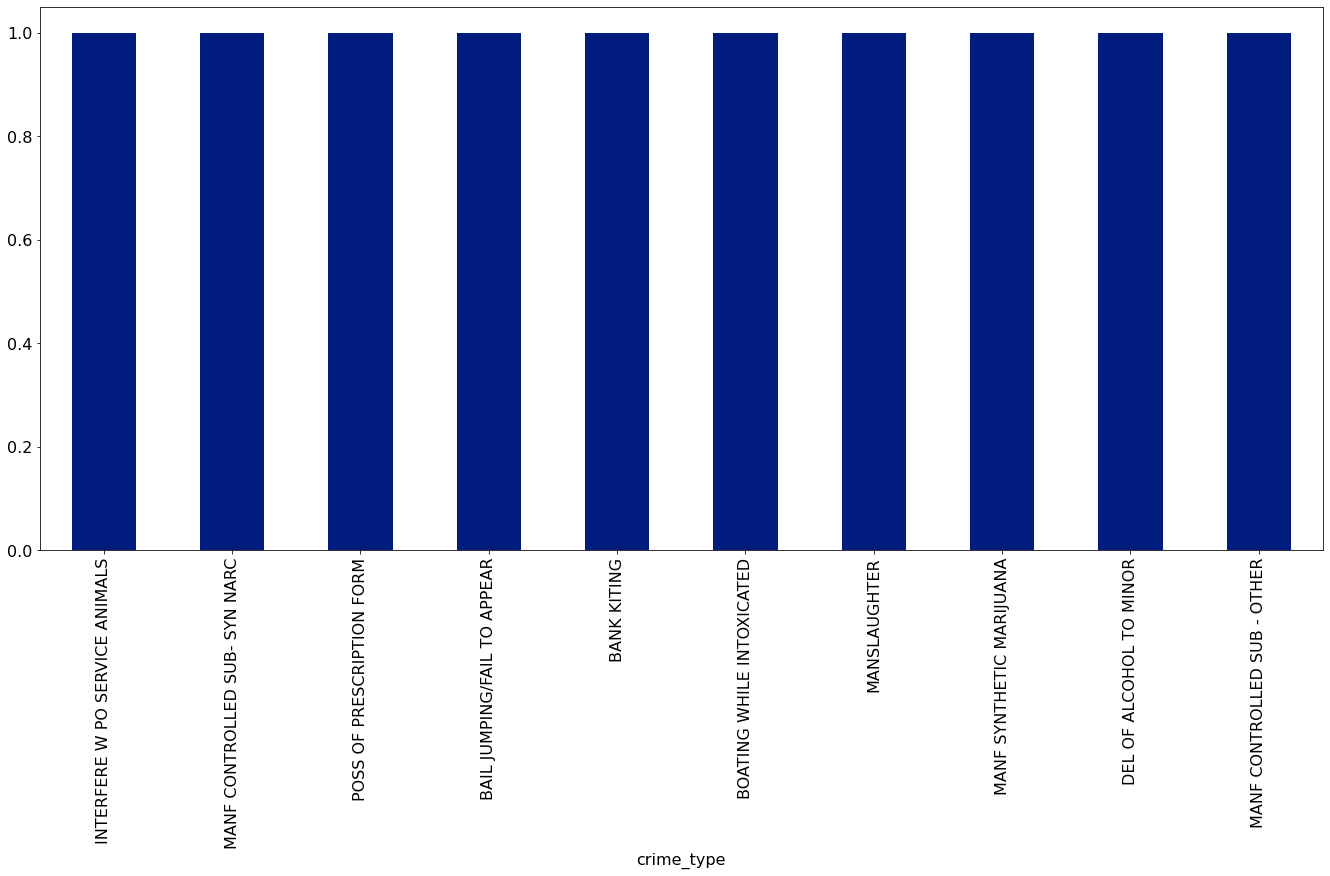

In [156]:
#Look at the top 10 crime types that get cleared
train2.groupby(['crime_type']).cleared.mean().sort_values(ascending = False).head(10).plot.bar();